# setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.environ["OMP_NUM_THREADS"] = '1'
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import rioxarray
import cmcrameri.cm

In [2]:
ibge = gpd.read_file(r'Data\IBGE\BiomasBrasil.shp')
shp_cerrado = ibge[ibge.biomas == 'CERRADO']
gdf = gpd.read_file('Data\stations.geojson').to_crs(ibge.crs)
df_cerrado = pd.read_pickle(r'Data\df_cerrado_bet.pkl')
gdf_filtered = gdf[gdf.Code.isin(df_cerrado.Code.unique())]
df_metrics = pd.read_csv(r'Data\df_metrics_bet.pkl', index_col=0)
gdf_metrics = gdf_filtered.merge(df_metrics, on='Code', how='left')
gdf_metrics = gdf_metrics.sort_values('Code').reset_index(drop=True)
palette = sns.color_palette('cmc.batlow', 3)

# KMEANS


In [6]:
gdf_kmeans = gdf_metrics.copy()

## hyperparameters

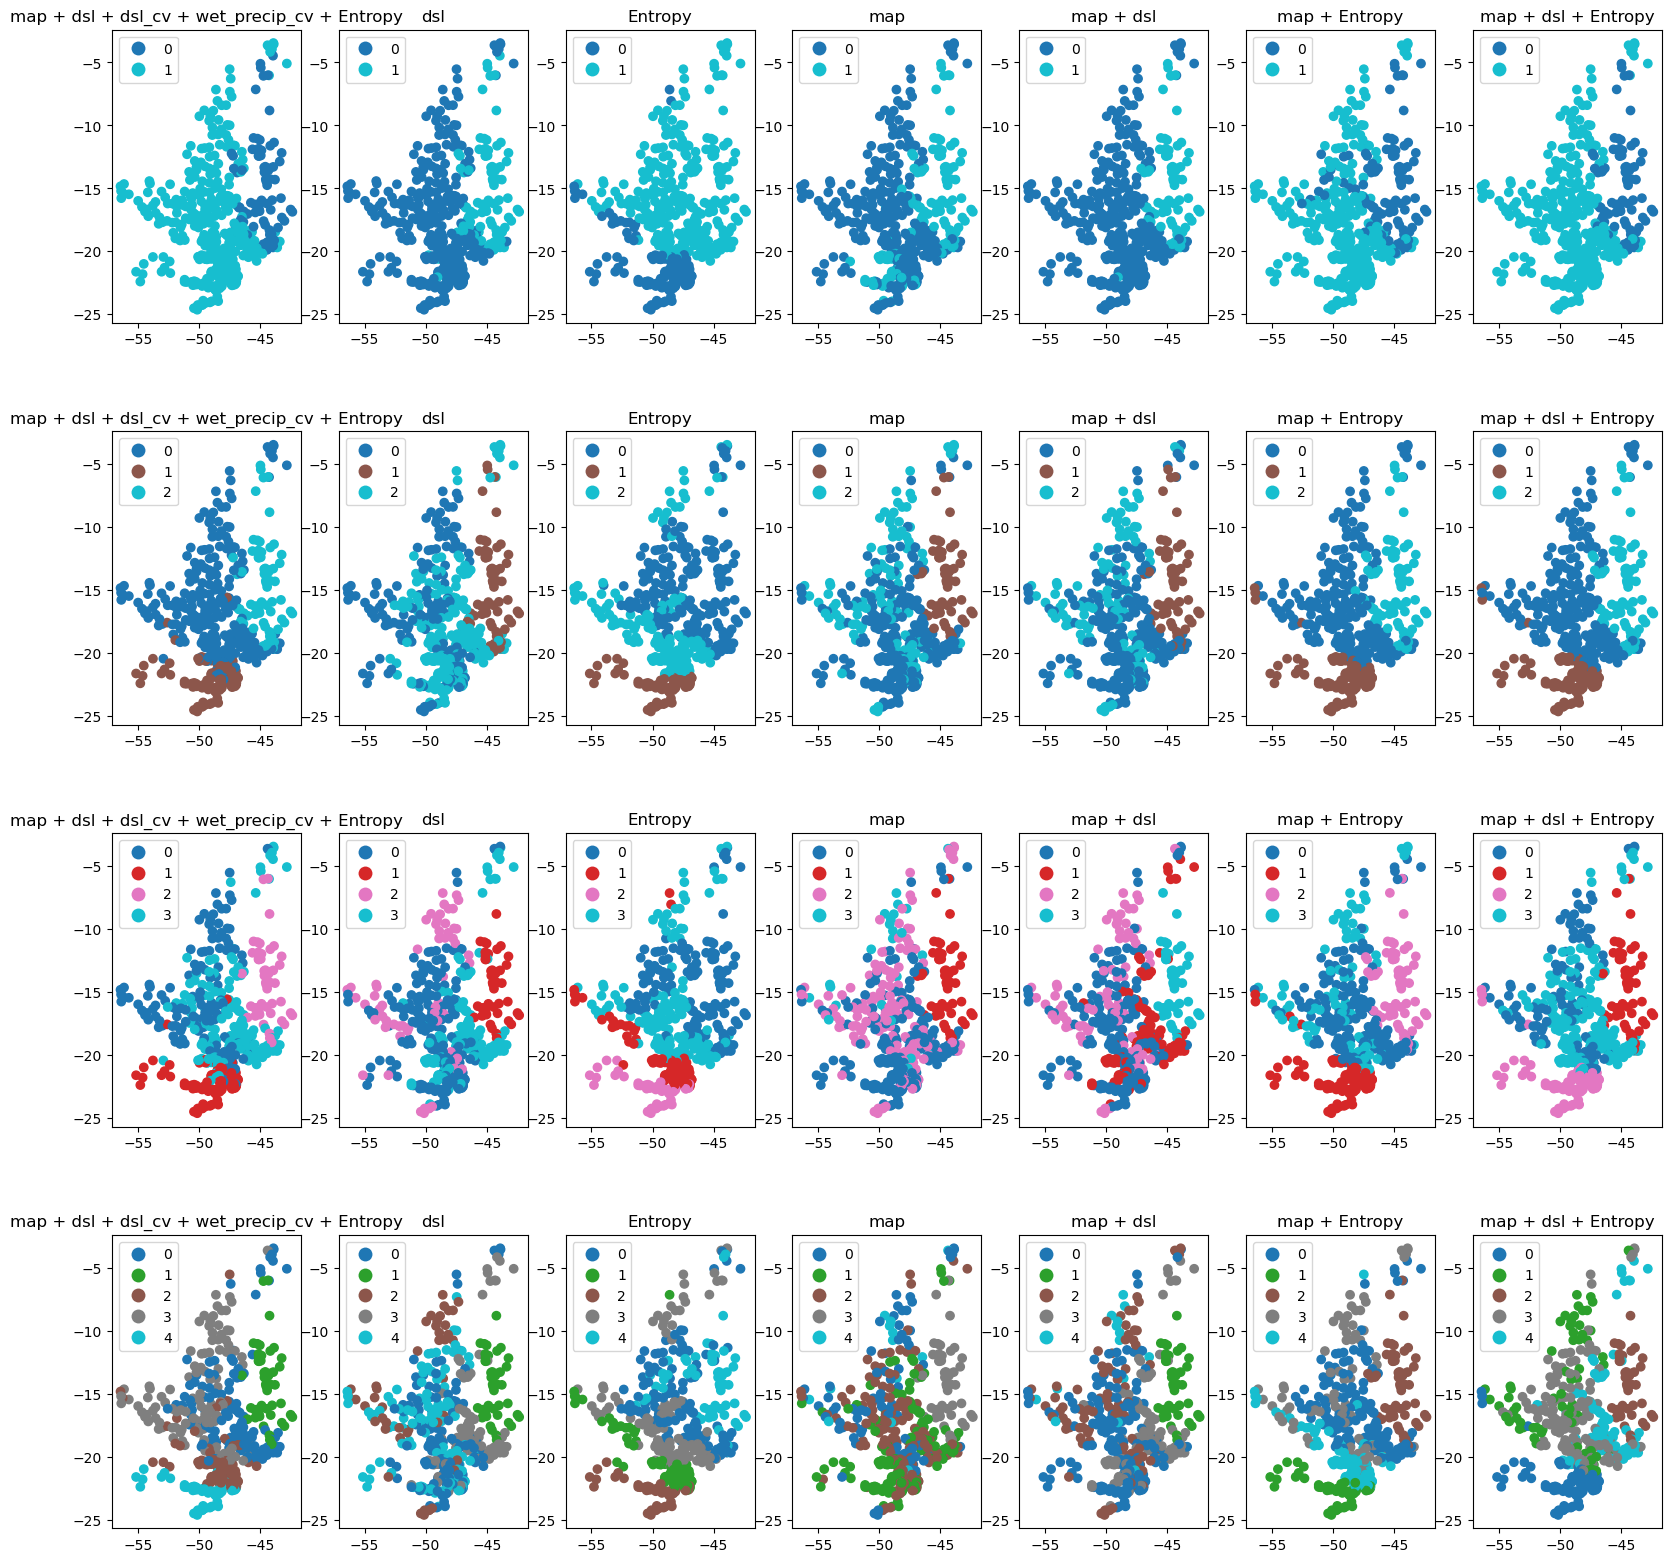

In [45]:
#plot kmeans cluster for each set of metrics and number of clusters
tests_metrics = [['map', 'dsl', 'dsl_cv', 'wet_precip_cv', 'Entropy'], ['dsl'], ['Entropy'], ['map'], ['map', 'dsl'], ['map', 'Entropy'],['map', 'dsl', 'Entropy']]
clusters = [2,3,4,5]
fig, axes = plt.subplots(len(clusters), len(tests_metrics), figsize=(20, 20))
for i, clust in enumerate(clusters):
    for m, metrics in enumerate(tests_metrics):
        model = KMeans(init='k-means++',
                        n_clusters=clust,
                        n_init=100,
                        max_iter=300,
                        random_state=42)
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(gdf_kmeans[metrics])
        gdf_kmeans['cluster'] = model.fit_predict(scaled_features)
        gdf_kmeans.plot(column='cluster', categorical=True, legend=True, ax=axes[i,m])
        axes[i,m].set_title(' + '.join(metrics))


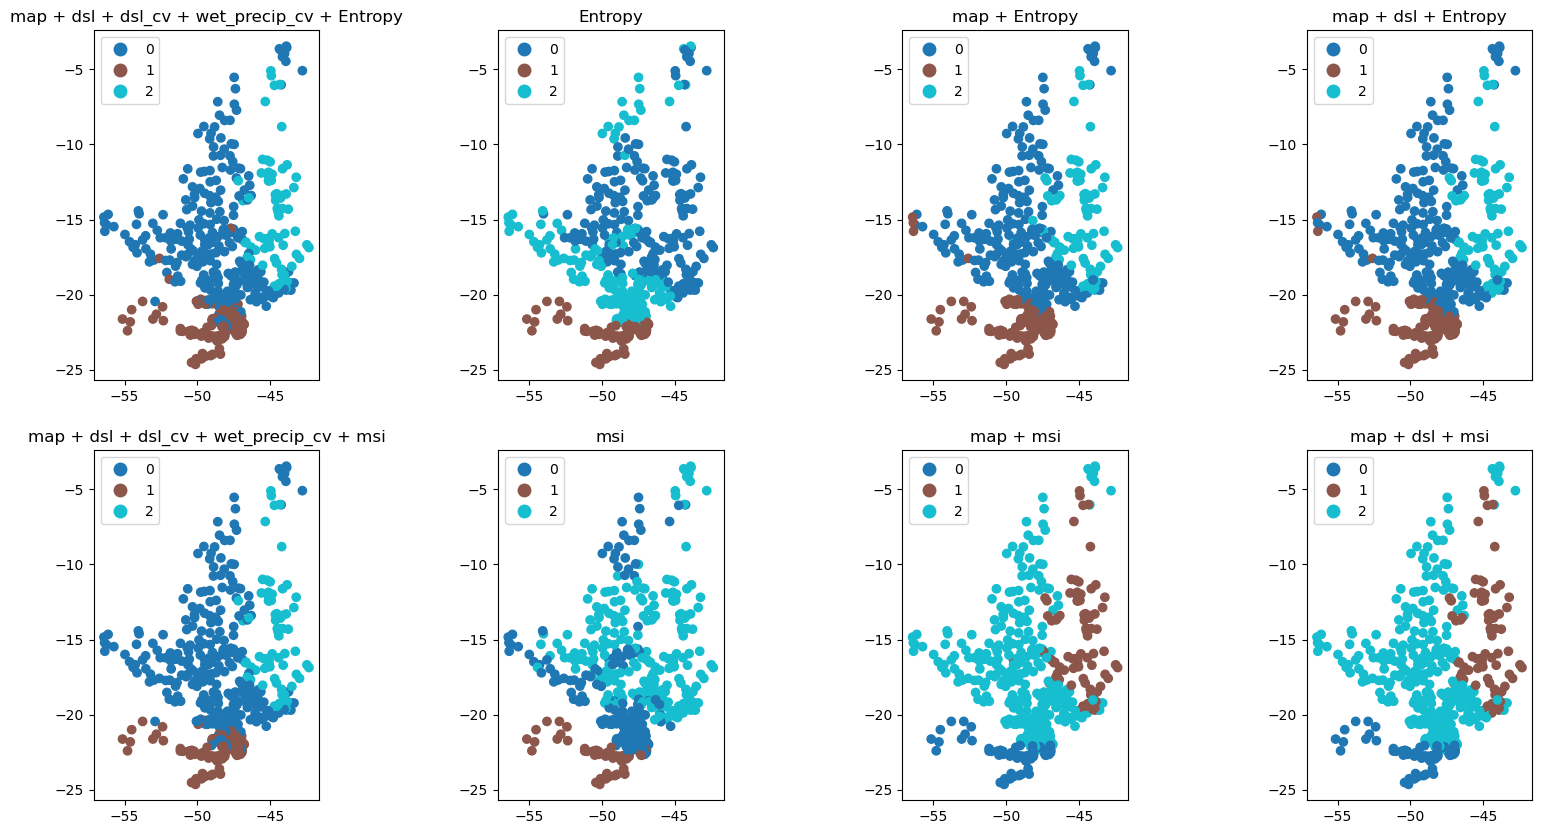

In [46]:
#compare entropy and msi
test_entropy = [['map', 'dsl', 'dsl_cv', 'wet_precip_cv', 'Entropy'], ['Entropy'], ['map', 'Entropy'],['map', 'dsl', 'Entropy']]
test_msi = [['map', 'dsl', 'dsl_cv', 'wet_precip_cv', 'msi'], ['msi'], ['map', 'msi'],['map', 'dsl', 'msi']]

fig, axes = plt.subplots(2, len(test_entropy), figsize=(20, 10))
for i, test in enumerate([test_entropy, test_msi]):
    for m, metrics in enumerate(test):
        model = KMeans(init='k-means++',
                        n_clusters=3,
                        n_init=100,
                        max_iter=300,
                        random_state=42)
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(gdf_kmeans[metrics])
        gdf_kmeans['cluster'] = model.fit_predict(scaled_features)
        gdf_kmeans.plot(column='cluster', categorical=True, legend=True, ax=axes[i,m])
        axes[i,m].set_title(' + '.join(metrics))

In [18]:
# calculate silhouette score and elbow method for each number os clusters
kmeans_kwargs = {
     "init": 'k-means++',
     "n_init": 1000,
     "max_iter": 300,
     "random_state": 42,
 }
 
sse = []
silhouette_coefficients = []
metrics = ['map', 'Entropy']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(gdf_kmeans[metrics])

for k in range(2, 11):
     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
     kmeans.fit(scaled_features)
     score = silhouette_score(scaled_features, kmeans.labels_)
     silhouette_coefficients.append(score)
     sse.append(kmeans.inertia_)

In [21]:
dff = pd.DataFrame({'k': range(2, 11), 'silhouette_coefficients': silhouette_coefficients, 'sse': sse})
dff.to_csv('Data\kmeans_hyperparam.csv')

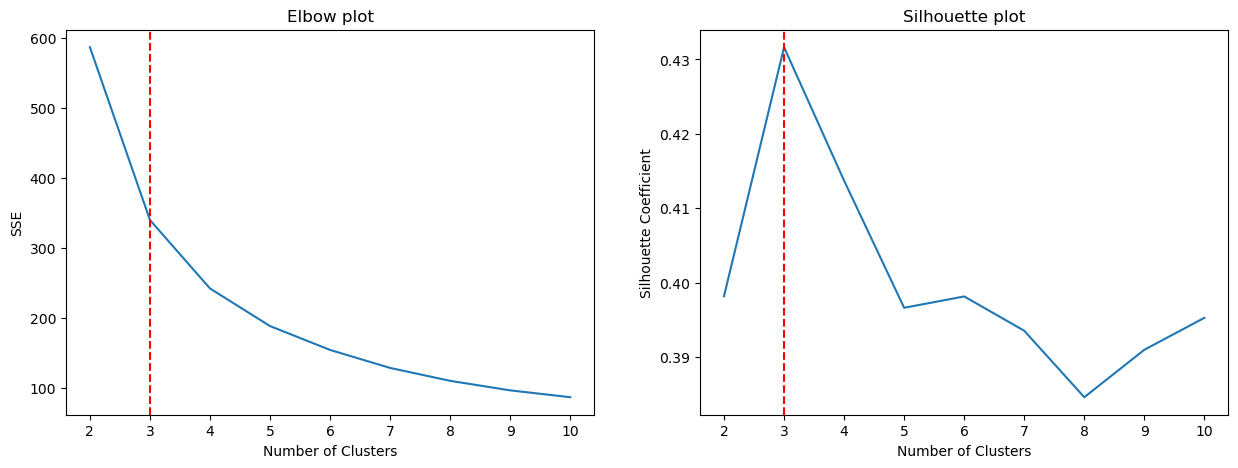

In [19]:
#plot elbow and silhouette
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(range(2, 11), sse)
axs[0].set_title('Elbow plot')
axs[0].set_xlabel("Number of Clusters")
axs[0].set_ylabel("SSE")
axs[0].axvline(x=3, color='red', linestyle='--')

axs[1].plot(range(2, 11), silhouette_coefficients)
axs[1].set_title('Silhouette plot')
axs[1].set_xlabel("Number of Clusters")
axs[1].set_ylabel("Silhouette Coefficient")
axs[1].axvline(x=3, color='red', linestyle='--')
plt.show()


## best model

Text(0.5, 1.0, "['map', 'Entropy']")

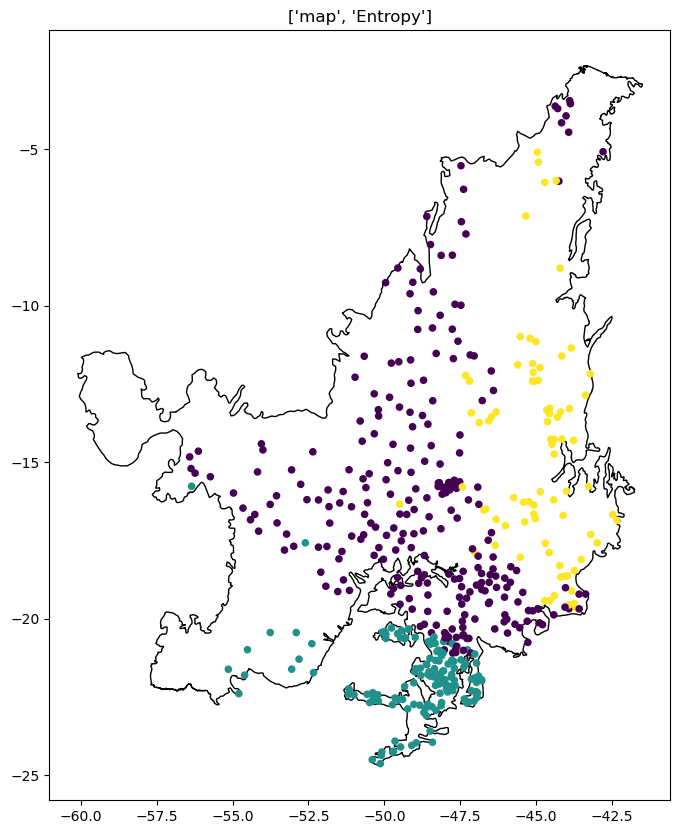

In [13]:
metrics = ['map', 'Entropy']

model = KMeans(
init='k-means++',
n_clusters=3,
n_init=2000,
max_iter=300,
random_state=42)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(gdf_kmeans[metrics])
kmeans = model.fit(scaled_features)
gdf_kmeans['cluster_kmeans'] = kmeans.labels_

fig, ax = plt.subplots(figsize=(10,10))
shp_cerrado.plot(ax = ax, color='white', edgecolor='black')
gdf_kmeans.plot(ax=ax, column='cluster_kmeans', markersize=20, cmap='viridis')
ax.set_title(metrics)

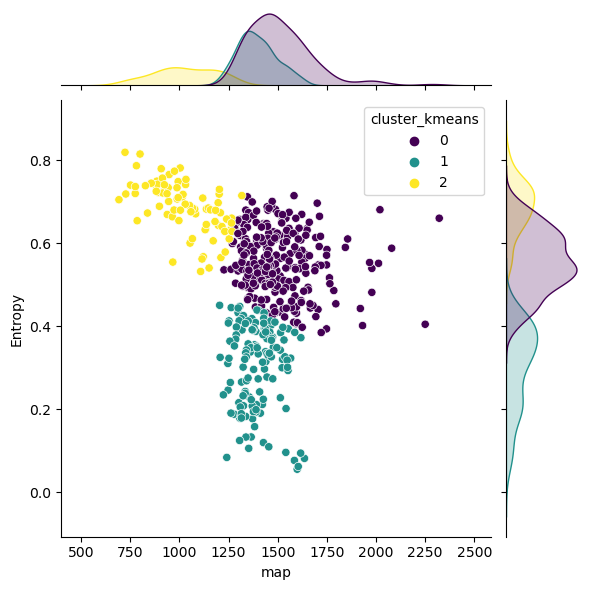

In [15]:
# plot a jointplot
g = sns.jointplot(data=gdf_kmeans, x='map', y='Entropy', hue='cluster_kmeans', palette='viridis')
#save fig
#g.savefig('kmeans_jointplot.png')

In [80]:
#drop cluster column and save to csv
#gdf_kmeans.drop(columns='cluster', inplace=True)
#gdf_kmeans.to_csv('Data\gdf_kmeans.csv')

# KNN

In [16]:
# settings for knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
gdf_knn = gdf_kmeans.copy()
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .2, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(gdf_knn[['Latitude', 'Longitude']].values, gdf_knn['cluster_kmeans'].values, test_size=0.2, random_state=42)
#settings for spatial
lat_min = 0
lat_max = -26
lon_min = -61
lon_max = -40
h = 0.1
yy, xx = np.meshgrid(
    np.arange(lon_min, lon_max, h),
    np.arange(lat_max, lat_min, h)
                     )
xy = np.c_[xx.ravel(), yy.ravel()]        

## hyperparameters

In [7]:
#best models
k_range= np.arange(3,11)
steps = [#('scalar', StandardScaler()),
         ('KNN', KNeighborsClassifier())
         ]
pipeline = Pipeline(steps)

parameters = {'KNN__n_neighbors':k_range}

grid = GridSearchCV(pipeline,param_grid=parameters,cv=cv, n_jobs=-1)
grid.fit(X_train,y_train)
model = grid.best_estimator_
print("Accuracy: {}".format(grid.score(X_test, y_test)))
print("Tuned Model Parameters: {}".format(grid.best_params_))


Accuracy: 0.90625
Tuned Model Parameters: {'KNN__n_neighbors': 3}


Text(0, 0.5, 'Accuracy')

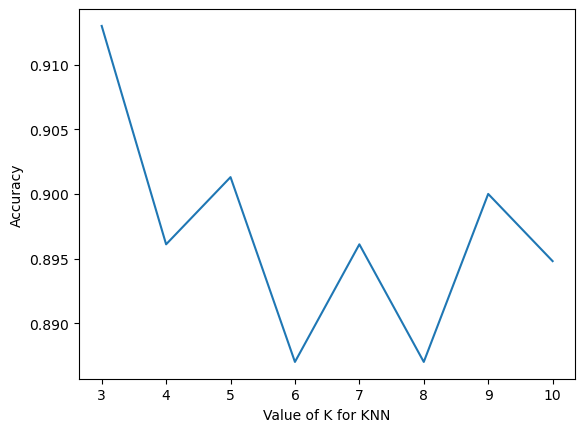

In [8]:
plt.plot(k_range, grid.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy')

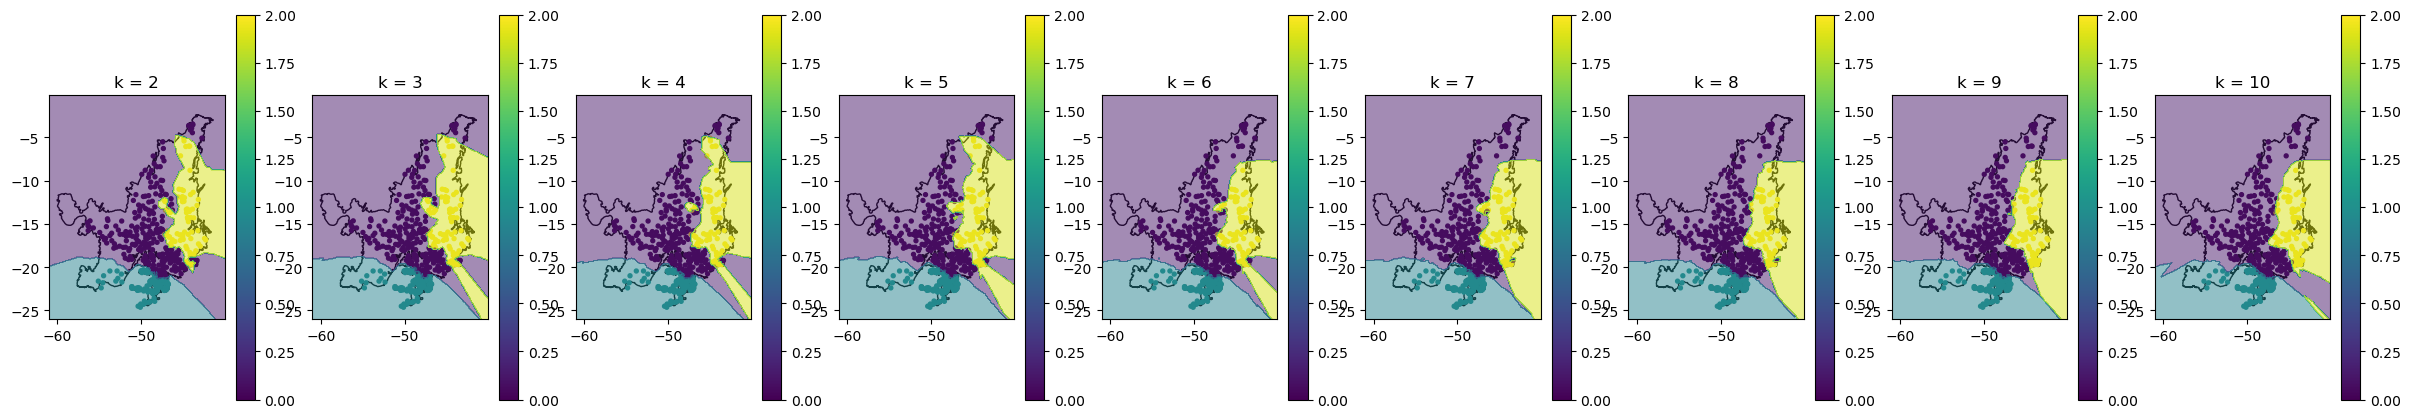

In [215]:
# create a plot with different k 
num_plots = 9
k_min = 2
fig, axes = plt.subplots(1, num_plots, figsize=(30, 5))
for k in range(0, num_plots):
    shp_cerrado.plot(ax = axes[k], color='white', edgecolor='black')
    model = KNeighborsClassifier(n_neighbors=k+k_min )
    model.fit(X_train, y_train)
    gdf_knn['knn'] = model.predict(gdf_knn[['Latitude', 'Longitude']].values)
    
    Z = model.predict(xy)
    Z = Z.reshape(xx.shape)  
    gdf_knn.plot(ax=axes[k], column='knn', markersize=8, cmap='viridis', legend=True)
    axes[k].contourf(yy, xx, Z, cmap='viridis', alpha=0.5)
    axes[k].set_title('k = {}'.format(k+k_min ))

## best model

In [17]:
# knn with 3 neighbors
h2 = 0.05
k= 3
yy2, xx2 = np.meshgrid(
    np.arange(lon_min, lon_max, h2),
    np.arange(lat_max, lat_min, h2)
                     )
xy2 = np.c_[xx2.ravel(), yy2.ravel()] 
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)
gdf_knn['knn'] = model.predict(gdf_knn[['Latitude', 'Longitude']].values)
Z = model.predict(xy2)
Z = Z.reshape(xx2.shape)  

<AxesSubplot: >

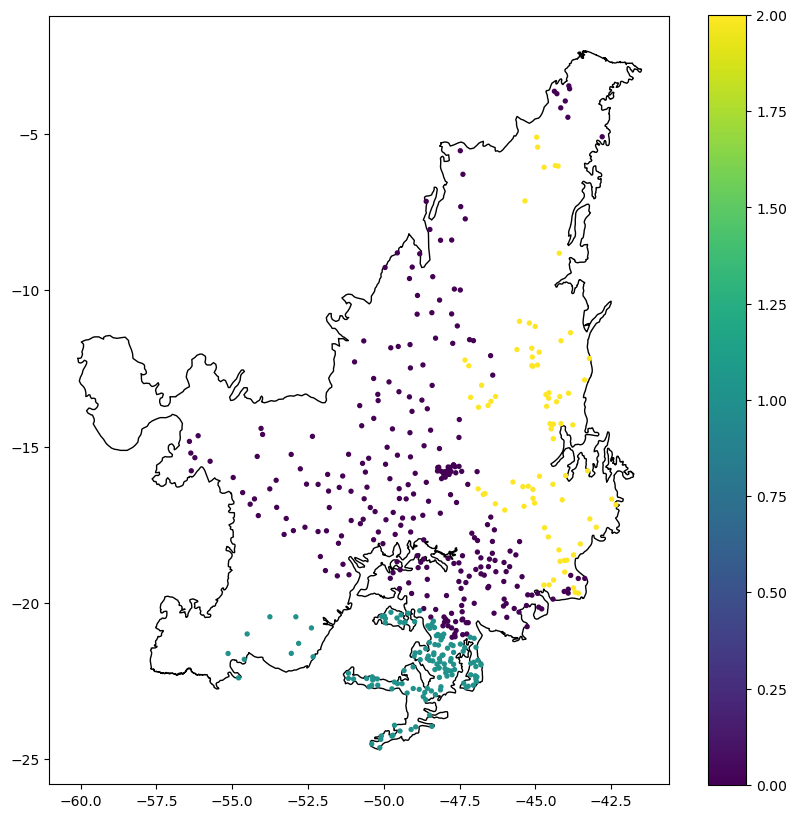

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
shp_cerrado.plot(ax = ax, color='white', edgecolor='black')
gdf_knn.plot(ax=ax, column='knn', markersize=8, cmap='viridis', legend=True)

<AxesSubplot: >

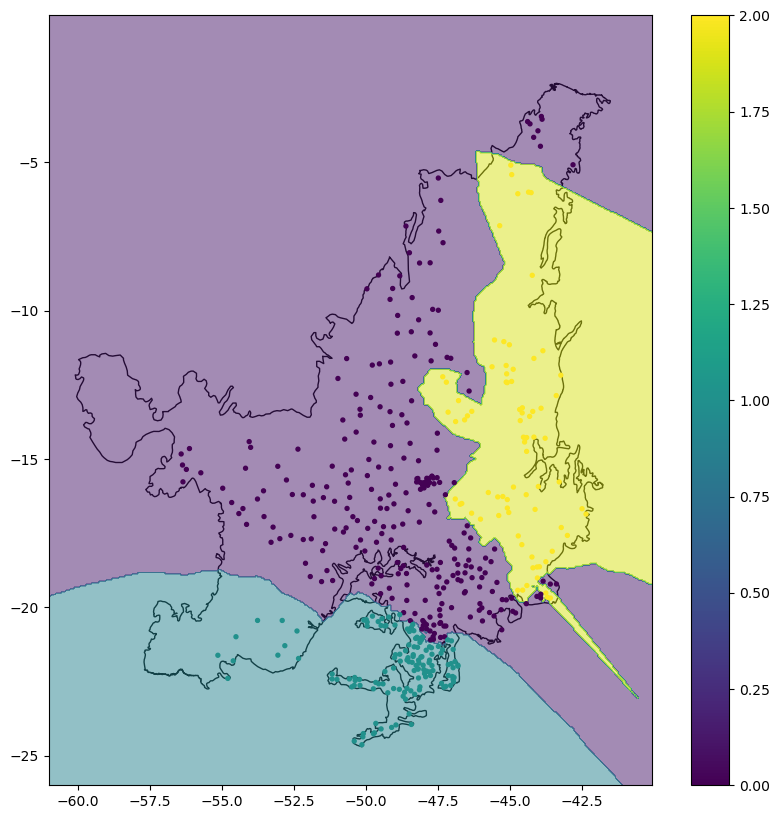

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
shp_cerrado.plot(ax = ax, color='white', edgecolor='black')
ax.contourf(yy2, xx2, Z, cmap='viridis', alpha=0.5)
gdf_knn.plot(ax=ax, column='knn', markersize=8, cmap='viridis', legend=True)

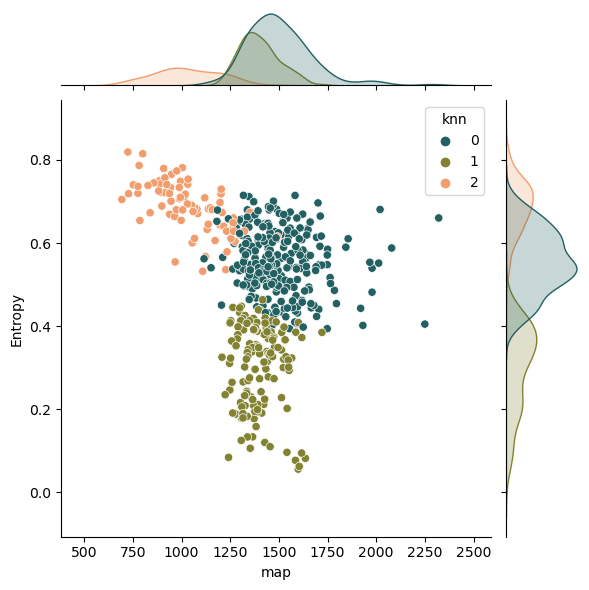

In [20]:
sns.jointplot(data=gdf_knn, x='map', y='Entropy', hue='knn', palette=palette)


In [21]:
gdf_knn['region'] = gdf_knn['knn'].replace({0: 'Central', 1: 'Southern', 2: 'Eastern'})

In [22]:
#gdfknn to geojson
gdf_knn.to_file(r'Data\gdf_knn_bet.geojson', driver='GeoJSON')

# Save Regions

## xarray

In [23]:
# transform KNN to xarray
xarr = xr.DataArray(Z, coords=[xx2[:,0], yy2[0,:]], dims=['lat', 'lon'])
xarr = xarr.rename({'lat': 'latitude', 'lon': 'longitude'})
xarr.rio.set_crs(shp_cerrado.crs, inplace=True)
cliped2 = xarr.rio.clip(shp_cerrado.geometry.values, shp_cerrado.crs)
cliped = cliped2.where(cliped2 >= 0)


<AxesSubplot: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

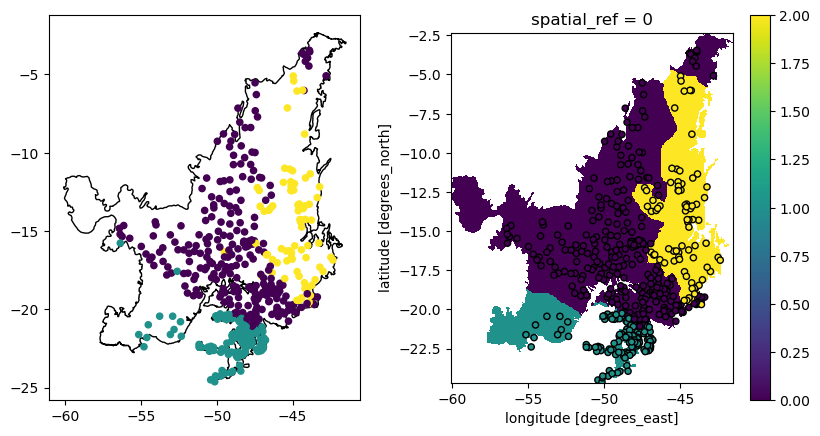

In [24]:
# pplot knn and kmeans
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
shp_cerrado.plot(ax = ax[0], color='white', edgecolor='black')
gdf_knn.plot(ax=ax[0], column='cluster_kmeans', markersize=20, cmap='viridis')
cliped.plot(ax=ax[1], cmap='viridis')
gdf_knn.plot(ax=ax[1], column='knn', markersize=20, cmap='viridis',edgecolors= "black")

In [25]:
ds = cliped.to_dataset(name='knn')
#save cllipped
ds.rio.to_raster('Data\knn_cerrado.tif')
#save clipped as nc
ds.to_netcdf('Data\knn_cerrado.nc')
cliped2.rio.to_raster('Data\knn_cerrado.tif')


## geopandas and shapefiles

In [ ]:
#using countorf, its a mess

#https://gis.stackexchange.com/questions/99917/converting-matplotlib-contour-objects-to-shapely-objects
#df = pd.DataFrame()
#poly_levels = []
#levels = []
#
#for k in [0,1,2]:
#    knn_contour = ds_knn.knn.where(ds_knn.knn == k).plot.contourf(levels=2)
#    for i, collection in enumerate(knn_contour.collections):
#
#        for path in collection.get_paths():
#            if path.to_polygons():
#                for npoly, polypoints in enumerate(path.to_polygons()):
#                    poly_lons = polypoints[:, 0]
#                    poly_lats = polypoints[:, 1]
#                    # be careful with the following---check to make sure
#                    # your coordinate system expects lat first, lon second
#                    poly_init = Polygon([coords for coords in \
#                                         zip(poly_lons,poly_lats)])
#                    if poly_init.is_valid:
#                        poly_clean = poly_init
#                    else:
#                        poly_clean = poly_init.buffer(0.)
#                    if npoly == 0:
#                        poly = poly_clean
#                    else:
#                        poly = poly.difference(poly_clean)
#                    poly_levels.append(poly)
#                    levels.append(k)
#
#
#
#
#
#    gdf1 = gpd.GeoDataFrame({'level':levels, 'geometry':poly_levels}).dissolve(by='level')              
#    gdf1.crs = shp_cerrado.crs                
#                

In [26]:
from osgeo import gdal, ogr, osr
#create polygons from xarray
raster = gdal.Open(r'Data\knn_cerrado3_2.tif')
band = raster.GetRasterBand(1)
array = band.ReadAsArray()
proj = raster.GetProjection()
shp_proj = osr.SpatialReference()
shp_proj.ImportFromWkt(proj)
output_file = r'Data\regions.shp'
call_drive = ogr.GetDriverByName('ESRI Shapefile')
create_shp = call_drive.CreateDataSource(output_file)

shp_layer = create_shp.CreateLayer('Data\layer', srs= shp_proj)
new_field = ogr.FieldDefn(str('ID'), ogr.OFTInteger)
shp_layer.CreateField(new_field)

gdal.Polygonize(band, None, shp_layer, 0, [], callback=None)
create_shp.Destroy()
raster = None

In [27]:
regions = gpd.read_file('data/regions.shp')
regions1 = regions[regions['ID'] != 2147483647].dissolve(by='ID')
regions1['region'] = ['Central', 'Southern', 'Eastern']
regions1.to_file(r'Data\regions1.geojson', driver='GeoJSON')

In [39]:
from shapely.geometry import mapping
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
import fiona

In [40]:
# Define a polygon feature geometry with one attribute
for i in [0,1,2]:
    poly = regions1.geometry[i]
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }
    
    # Write a new Shapefile
    with fiona.open(r'Data\regions\cluster' + str(i) + '.shp', 'w', 'ESRI Shapefile', schema) as c:
        ## If there are multiple geometries, put the "for" loop here
        c.write({
            'geometry': mapping(poly),
            'properties': {'id': 123},
        })